In [82]:
#E-commerce User Segmentation
#RFM Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rc('font', family = 'Apple SD Gothic Neo')
plt.rcParams['axes.unicode_minus'] = False

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
#to find relations and patterns -> Association Rule Learning(Apriori, Eclat, FP-Growth)

from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import silhouette_visualizer
from sklearn.preprocessing import RobustScaler

from lightgbm import LGBMClassifier

import warnings

# DeprecationWarning Ignore
warnings.filterwarnings('ignore', category=DeprecationWarning)

# 0. Load Data

In [203]:
data_customer = pd.read_csv('/Users/jeonseungmi/Projects/ecm/ecm_Customer_info.csv')
data_marketing = pd.read_csv('/Users/jeonseungmi/Projects/ecm/ecm_Marketing_info.csv')
date_onlinesales = pd.read_csv('/Users/jeonseungmi/Projects/ecm/ecm_Onlinesales_info.csv')
data_tax = pd.read_csv('/Users/jeonseungmi/Projects/ecm/ecm_Tax_info.csv')

data_discount = pd.read_csv('/Users/jeonseungmi/Projects/ecm/ecm_Discount_info.csv')
data_discount['Trans_Month'] = data_discount['Month'].map({'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12})
data_discount = data_discount.drop(columns = 'Month')

## Merge several data

In [205]:
data_raw = date_onlinesales.merge(data_customer, how = 'left', on = ['User ID'])
data_raw = data_raw.merge(data_tax, how = 'left', on = ['Product Category'])

data_raw['Trans_Month'] = data_raw['Date'].apply(lambda x: x[0:2]).astype(int)
#extract month from 'date' column of DataFrame: it depends on date type of original data

data_raw = data_raw.merge(data_discount, how = 'left', on = ['Product Category', 'Trans_Month'])
data_raw['Date'] = pd.to_datetime(data_raw['Date'])

data_raw = data_raw.drop(columns = 'Coupon Code')
data_raw.loc[~(data_raw['Coupon Status'] == 'Used'), 'Discount Rate'] = 0
data_raw['Discount Rate'] = data_raw['Discount Rate'].fillna(0)

/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_99097/696911765.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_raw['Date'] = pd.to_datetime(data_raw['Date'])


Total Transaction Amount = (Quant * Avg Price * (1-Discount Rate/100) * (1+GST)) + Delivery Fee

In [208]:
data_raw['Trans_Amount'] = (data_raw['Quant'] * data_raw['Avg Price'] * (1-data_raw['Discount Rate']/100) * (1+data_raw['GST'])) + data_raw['Delivery Fee']

print(data_raw.shape)
data_raw.head()

(52924, 16)


,User ID,Trans ID,Date,Product ID,Product Category,Quant,Avg Price,Delivery Fee,Coupon Status,Gender,Location,Periods,GST,Trans_Month,Discount Rate,Trans_Amount
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,male,Chicago,12,0.10,1,10.0,158.6729
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,male,Chicago,12,0.10,1,10.0,158.6729
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,male,Chicago,12,0.10,1,10.0,8.5295
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,male,Chicago,12,0.18,1,0.0,109.9270
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,male,Chicago,12,0.18,1,10.0,24.0230


# 1. RFM(Recency, Frequency, Monetary)

## Define R, F, M variables

In [212]:
today = pd.to_datetime('2020-01-01') # 2019 Data -> Define 2020-01-01 as recent date
segment = data_raw.groupby('User ID').agg({'Date' : lambda x: (today - x.max()).days, #Recency = Days since last transaction
                                           'Trans ID' : 'count', #Frequency = Number of transactions in 2019
                                           'Trans_Amount' : 'sum'}) #Monetary = Total transaction amount in 2019

segment.columns = ['R_Days', 'F_transnumbers', 'M_transamount']
segment.head()

,R_Days,F_transnumbers,M_transamount
User ID,,,
USER_0000,108,2,174.98174
USER_0001,60,60,15686.84396
USER_0002,74,23,1689.55594
USER_0003,18,17,1467.43528
USER_0004,108,36,2007.42900


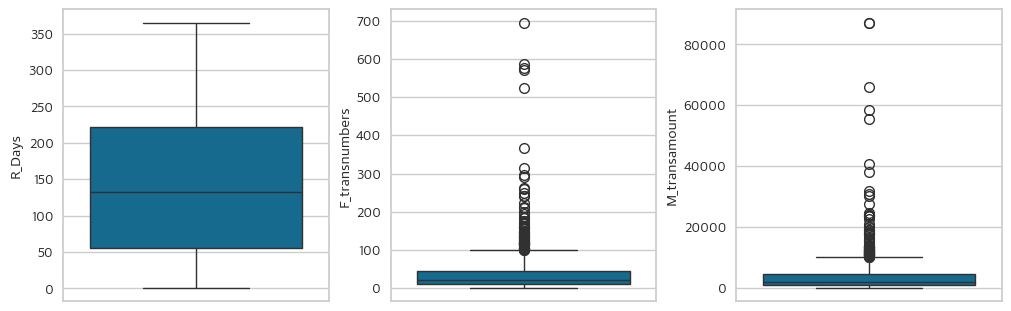

In [214]:
fig,ax = plt.subplots(1,3, figsize = (10,3), constrained_layout = True)
for i,c in enumerate(list(segment.columns)) :
    sns.boxplot(y = segment[c], ax = ax[i])
plt.show()

`R_Days`: Distribute evenly over the period, Divide using quantiles into five groups (0, 0.2, 0.4, 0.6, 0.8, 1.0).

`F_transnumbers` and `M_transamount`: Reflect outliers and divide into five groups (0, 0.25, 0.5, 0.75, 0.75 + IQR x 1.5).

In [217]:
segment.describe()

,R_Days,F_transnumbers,M_transamount
count,1468.000000,1468.000000,1468.000000
mean,145.292234,36.051771,3676.674895
std,101.936959,50.885680,5846.082106
min,1.000000,1.000000,6.990000
25%,56.000000,10.000000,783.974310
50%,132.000000,21.000000,2011.622610
75%,221.000000,46.000000,4495.056630
max,365.000000,695.000000,87200.896260


In [219]:
def calculatet_outlier(df,column):
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    out = df[column].quantile(0.75) + iqr*1.5
    return out

## Define R,F,M segment

In [222]:
segment['R'] = pd.qcut(segment['R_Days'], q = [0, 0.2,0.4, 0.6, 0.8, 1],
                              labels=[5,4,3,2,1]).astype(int)
segment['F'] = pd.cut(segment['F_transnumbers'], bins = [0, 10, 21, 46, calculatet_outlier(segment,'F_transnumbers'), max(segment['F_transnumbers'])], 
                              labels=[1,2,3,4,5]).astype(int)
segment['M'] = pd.cut(segment['M_transamount'], bins = [0, 784, 2011, 4495, calculatet_outlier(segment,'M_transamount'), max(segment['M_transamount'])],
                              labels=[1,2,3,4,5]).astype(int)
segment.head()

,R_Days,F_transnumbers,M_transamount,R,F,M
User ID,,,,,,
USER_0000,108,2,174.98174,3,1,1
USER_0001,60,60,15686.84396,4,4,5
USER_0002,74,23,1689.55594,4,3,2
USER_0003,18,17,1467.43528,5,2,2
USER_0004,108,36,2007.42900,3,3,2


# 2. Clustering

In [225]:
features = segment[['R_Days', 'F_transnumbers', 'M_transamount']]

sc = RobustScaler() #need less sensitive scaler(RobustScaler) b/c outliers for F & M variables
scaled_features = pd.DataFrame(sc.fit_transform(features), columns = features.columns)

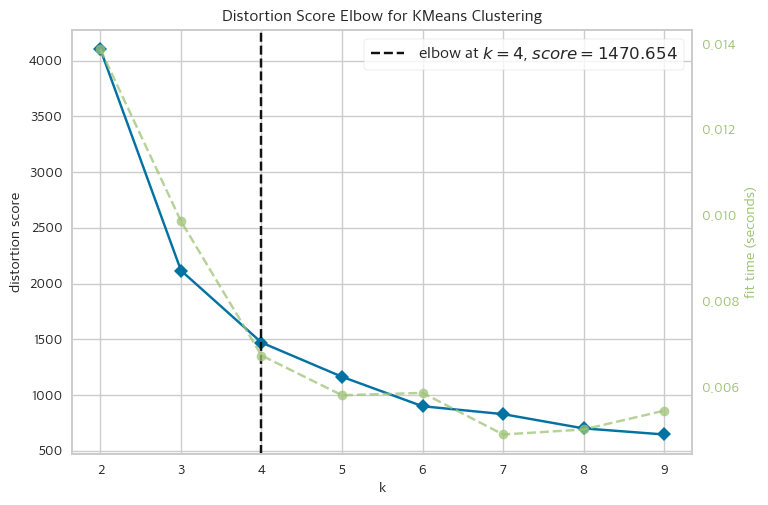

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9, random_state=42), k=(2, 10))

In [227]:
kelbow_visualizer(KMeans(random_state=42), scaled_features, k=(2,10))

In [229]:
#cluster group becomes 4 b/c of elbow plot
best_k = 4

kmeans = KMeans(n_clusters = best_k, random_state = 42)
segment['cluster'] = kmeans.fit_predict(scaled_features)
segment.head()

,R_Days,F_transnumbers,M_transamount,R,F,M,cluster
User ID,,,,,,,
USER_0000,108,2,174.98174,3,1,1,0
USER_0001,60,60,15686.84396,4,4,5,1
USER_0002,74,23,1689.55594,4,3,2,0
USER_0003,18,17,1467.43528,5,2,2,0
USER_0004,108,36,2007.42900,3,3,2,0


/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_99097/2261466553.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y = segment[c], x = segment['cluster'], order = [0,1,3,2], palette='Blues')


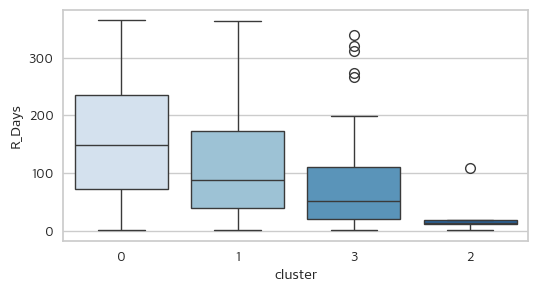

/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_99097/2261466553.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y = segment[c], x = segment['cluster'], order = [0,1,3,2], palette='Blues')


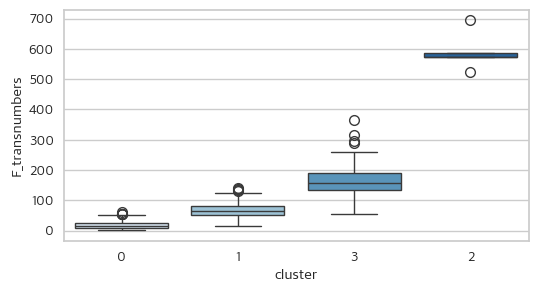

/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_99097/2261466553.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y = segment[c], x = segment['cluster'], order = [0,1,3,2], palette='Blues')


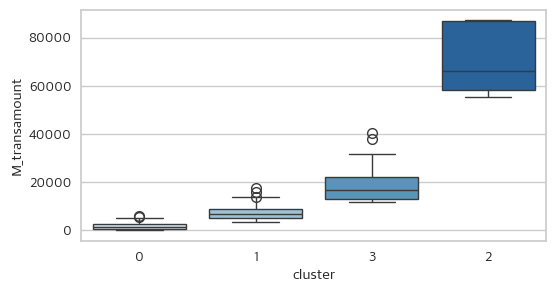

In [231]:
for i,c in enumerate(list(segment.columns[:3])):
    plt.figure(figsize = (6,3))
    sns.boxplot(y = segment[c], x = segment['cluster'], order = [0,1,3,2], palette='Blues')
    plt.show()

As a result, each cluster reflects characteristics of RFM variables.
Thus, set the weights using the cluster labels as the dependent variables.

# 3. Set weights of RFM with K-Means

1. Set the clustering results as the dependent variables
2. Determine the influence of variables affecting clustering results through dependent variable prediction
3. Set the weights for each RFM variable based on feature importance
4. Calculate the final RFM score

## Calculate the weights

/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_99097/1682381553.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = lgbm.feature_importances_, y = X.columns, palette='Blues')


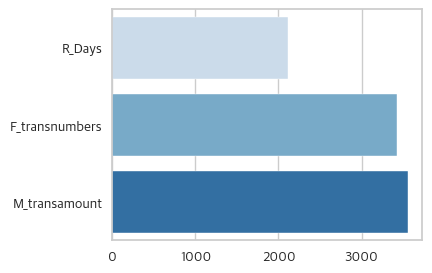

R_Days: 0.23
F_transnumbers: 0.38
M_transamount: 0.39


In [237]:
X = scaled_features; y = segment['cluster']

lgbm = LGBMClassifier(random_state = 42, verbose=-1)
lgbm.fit(X,y)

plt.figure(figsize = (4,3))
sns.barplot(x = lgbm.feature_importances_, y = X.columns, palette='Blues')
plt.ylabel('')
plt.show()

#calculate the weights
scores = lgbm.feature_importances_ / sum(lgbm.feature_importances_)
for i,c in enumerate(X.columns):
    print(f'{c}: {round(scores[i],2)}')

## User Segmentation (Standard > Silver > Gold > Black > Platinum)

In [240]:
def customer(RFM_Segment):
    if RFM_Segment <= 20:
        return 'Standard'
    elif RFM_Segment <= 40:
        return 'Silver'
    elif RFM_Segment <= 60:
        return 'Gold'
    elif RFM_Segment <= 80:
        return 'Black'
    else:
        return 'Platinum'

#calculate the fina RFM score and customer grade
segment['RFM_score'] = (segment['R']*scores[0] + segment['F']*scores[1] + segment['M']*scores[2])/5*100
segment['cus_grade'] = segment['RFM_score'].apply(customer)

In [242]:
segment['cus_grade'].value_counts(normalize = True).reindex(['Standard','Silver','Gold','Black', 'Platinum'])*100

cus_grade
Standard     5.858311
Silver      28.610354
Gold        27.997275
Black       26.975477
Platinum    10.558583
Name: proportion, dtype: float64

In [244]:
segment.groupby('cus_grade')['M_transamount'].sum().sort_values() / segment['M_transamount'].sum()*100

cus_grade
Standard     0.414465
Silver       5.392303
Gold        16.358921
Black       36.409287
Platinum    41.425024
Name: M_transamount, dtype: float64

`Black & Platinum` customers account for approximately 38% of the total number of customers, and contribute about 78% of the total revenue.

Thus, it is essential to focus on `Black & Platinum` customers segment.

-> examine detailed RFM segments for this purpose

# 4. Examine detailed RFM segments

## Preprocessing for visualizing segments

In [249]:
#Scaling
def RFM_scale(df):
    temp = df.copy()
    
    # Recency
    temp['R_interval'] = pd.qcut(df['R_Days'], 
                                 q = [0, 0.2,0.4, 0.6, 0.8, 1])
    left = temp['R_interval'].apply(lambda x: x.left).astype(int)
    right =  temp['R_interval'].apply(lambda x: x.right).astype(int)
    
    df['R_scale'] = (temp['R']-1) + ((temp['R_Days'] - left-0.01) / (right-left)) - 0.0001
    
    # Frequency
    temp['F_interval'] = pd.cut(df['F_transnumbers'], 
                                bins = [0, 10, 21, 46, calculatet_outlier(df,'F_transnumbers'), max(df['F_transnumbers'])])
    left = temp['F_interval'].apply(lambda x: x.left).astype(int)
    right =  temp['F_interval'].apply(lambda x: x.right).astype(int)
    
    df['F_scale'] = (temp['F']-1) + ((temp['F_transnumbers'] - left-0.01) / (right-left)) - 0.0001
    
    # Monetary
    temp['M_interval'] = pd.cut(df['M_transamount'], 
                                bins = [0, 784, 2011, 4495, calculatet_outlier(df,'M_transamount'), max(df['M_transamount'])])
    left = temp['M_interval'].apply(lambda x: x.left).astype(int)
    right =  temp['M_interval'].apply(lambda x: x.right).astype(int)
    
    df['M_scale'] = (temp['M']-1) + ((temp['M_transamount'] - left) / (right-left))-0.0001
    
    return df

## Visualized segmentation

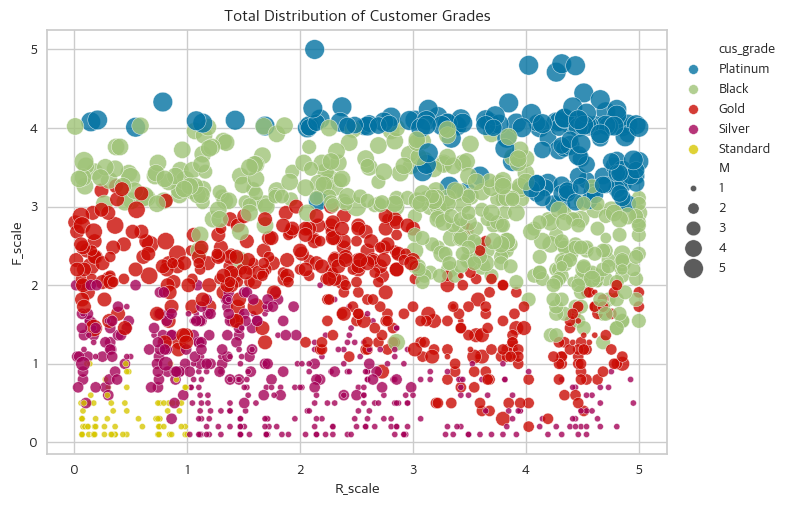

In [252]:
segment = RFM_scale(segment)
sns.scatterplot(x = segment['R_scale'], y = segment['F_scale'], alpha = 0.8
                ,size = segment['M'], sizes = (20,200)
                ,hue = segment['cus_grade'], hue_order = ['Platinum','Black','Gold','Silver','Standard']
               )
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
plt.title('Total Distribution of Customer Grades')
plt.show()

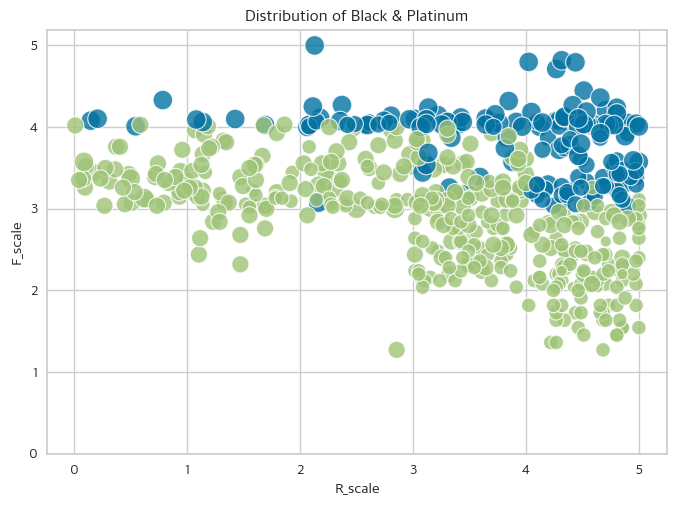

In [254]:
vip_segment = segment[segment['cus_grade'].isin(['Black','Platinum'])]
sns.scatterplot(x = vip_segment['R_scale'], y = vip_segment['F_scale'], alpha = 0.8
                ,size = vip_segment['M'], sizes = (20,200), size_norm = (1,5)
                ,hue = vip_segment['cus_grade'], legend = False
               )

plt.yticks([0,1,2,3,4,5])

#plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
plt.title('Distribution of Black & Platinum')
plt.show()

- `Black & Platinum` customer group is primarily distributed in the upper right side.
- BUT, there are also some customers with relatively lower RFM values.
- Therefore, a more detailed segmentation of the customer group is necessary for finer analysis.

## Detailed segmentation

In [258]:
def make_segment(r_interval, f_interval, m_interval):
    r_left, r_right = r_interval
    f_left, f_right = f_interval
    m_left, m_right = m_interval
    
    segment_idx = vip_segment['RFM_segment'].apply(lambda x: all([
                                                           r_left <= int(x[0])<= r_right
                                                          ,f_left <= int(x[1])<= f_right
                                                          ,m_left <= int(x[2])<= m_right
    ]))
    return segment_idx

In [260]:
vip_segment = segment[segment['cus_grade'].isin(['Black','Platinum'])]
vip_segment['RFM_segment'] = vip_segment['R'].map(str) + vip_segment['F'].map(str) + vip_segment['M'].map(str)
vip_segment['customer_segment'] = 'others'

#Categorize customers with more details
vip = make_segment((4,5),(4,5),(4,5)) #All of R,F,M >= 4
churn = make_segment((1,3),(3,5),(3,5)) #Low R(R<=3)
potential = make_segment((3,5),(1,3),(3,5)) #Low F(F<=3)
loyal = make_segment((3,5),(3,5),(1,3)) # Low M(M<=3)

vip_segment.loc[vip, 'customer_segment'] = 'VIP'
vip_segment.loc[churn, 'customer_segment'] = 'Churn'
vip_segment.loc[loyal, 'customer_segment'] = 'Loyal'
vip_segment.loc[potential, 'customer_segment'] = 'Potential'

/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_99097/1170394182.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vip_segment['RFM_segment'] = vip_segment['R'].map(str) + vip_segment['F'].map(str) + vip_segment['M'].map(str)
/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_99097/1170394182.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vip_segment['customer_segment'] = 'others'


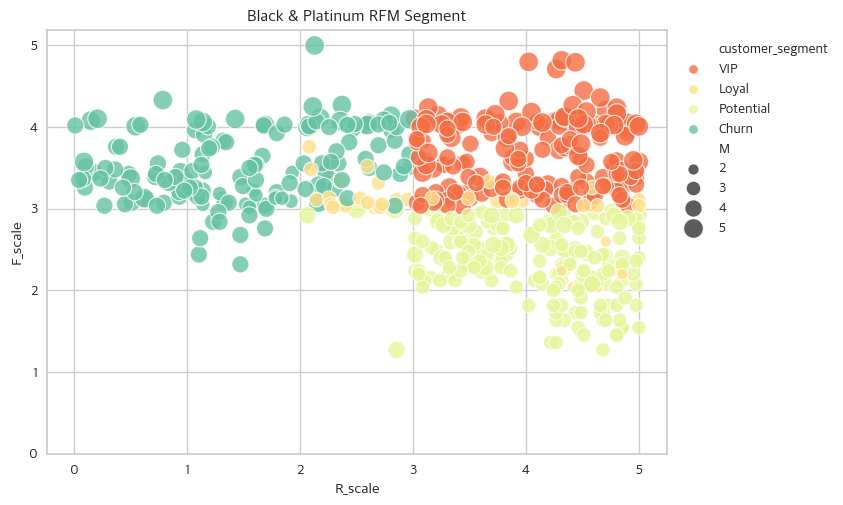

In [262]:
sns.scatterplot(x = vip_segment['R_scale'], y = vip_segment['F_scale'], alpha = 0.8
                ,size = vip_segment['M'], sizes = (20,200), size_norm = (1,5)
                ,hue = vip_segment['customer_segment'], palette='Spectral'
                ,hue_order = ['VIP','Loyal','Potential','Churn']
                ,legend = True
               )
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
plt.yticks([0,1,2,3,4,5])
plt.title('Black & Platinum RFM Segment')
plt.show()

- `VIP`: All R,F,M >=4
- `Churn`: Low R (R<=3)
- `Potential`: Low F (F<=3)
- `Loyal`: Low M (M<=3)

# 5. Propose customer segment strategies

In [266]:
data_cohort = data_raw.merge(vip_segment.reset_index()[['User ID','cus_grade','customer_segment']], how='left', on = 'User ID')
data_cohort = data_cohort[data_cohort['cus_grade'].isin(['Black','Platinum'])]

## 5-1. VIP Customer

- Analyze visit frequency and average sales by day of the week
- Compare after analyzing promotional costs by day of the week
- Propose effective promotions for VIP customers by adjusting promotional costs

### [Online and Offline promotion costs by weekday]

/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_99097/3107505287.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_marketing['Date'] = pd.to_datetime(data_marketing['Date'])
/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_99097/3107505287.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('weekday')[column].mean().plot.bar(ax=axes[i], title=column, colormap='Set3')
/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_99097/3107505287.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

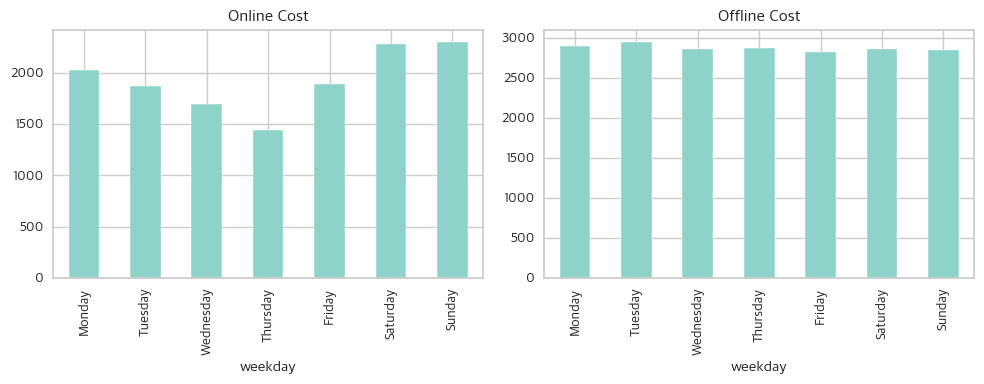

In [271]:
import calendar
data_cohort['weekday'] = data_cohort['Date'].dt.weekday
data_cohort['weekday'] = data_cohort['weekday'].apply(lambda x: calendar.day_name[x])

#Unify column names and data types
data_marketing = data_marketing.rename(columns={'date': 'Date'})
data_cohort['Date'] = pd.to_datetime(data_cohort['Date'])
data_marketing['Date'] = pd.to_datetime(data_marketing['Date'])

#Integrate data based on 'Date'
df = pd.merge(data_cohort, data_marketing, on = 'Date', how = 'inner')

#Specify label orderd
label_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['weekday'] = pd.Categorical(df['weekday'], categories=label_order, ordered=True)

#Select columns for each cost to plot the graph	
columns = ['Online Cost', 'Offline Cost']

#Create subplots for each cost to plot the graph
fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(10, 4))

#Plot the graph for each cost
for i, column in enumerate(columns):
    df.groupby('weekday')[column].mean().plot.bar(ax=axes[i], title=column, colormap='Set3')

#Adjust the layout for the entire graph
plt.tight_layout()
plt.show()

### [Transaction Count by weekday vs. Sales by weekday]

/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_99097/2108069201.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_counts.index, y=day_counts.values,
/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_99097/2108069201.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sales_counts.index, y=sales_counts.values,


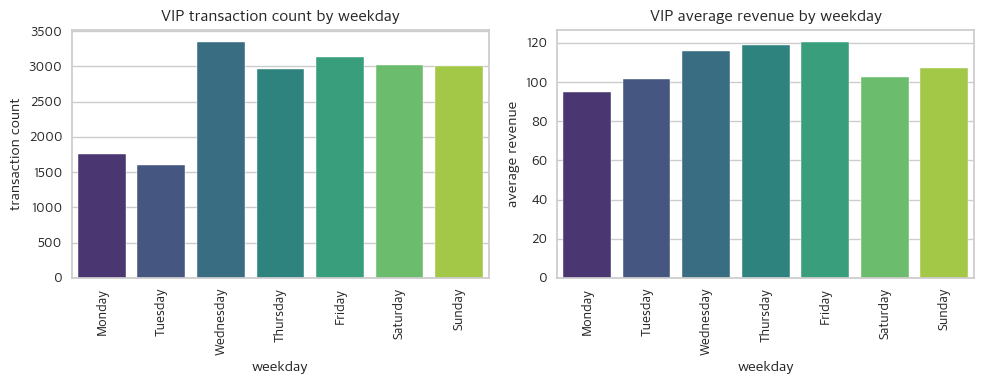

In [275]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
vip_cohort = data_cohort[data_cohort['customer_segment'] == 'VIP']

#Transaction Count by weekday
day_counts = vip_cohort['weekday'].value_counts() #Calculate transaction counts by weekday
sns.barplot(x=day_counts.index, y=day_counts.values, 
            order = label_order, ax=ax[0], palette='viridis')
ax[0].set_title('VIP transaction count by weekday')
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_xlabel('weekday')
ax[0].set_ylabel('transaction count')

#Sales by weekday
sales_counts = vip_cohort.groupby('weekday')['Trans_Amount'].mean() #Calculate average revenue by weekday
sns.barplot(x=sales_counts.index, y=sales_counts.values, 
            order = label_order, ax=ax[1], palette='viridis')
ax[1].set_title('VIP average revenue by weekday')
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_xlabel('weekday')
ax[1].set_ylabel('average revenue')

plt.tight_layout()
plt.show()

- According to the analysis of promotional costs be weekday, online costs are lowest on `Wednesday, Thursday`.
- According to the analysis of transaction counts and average sales shows that `Wednesday and Thursday` have the highest values.
- Therefore, propose an expansion of online promotional spending on `Wednesday and Thursday`.

## 5-2. Loyal Customer

- Propose strategies to increase transaction amounts for loyal customers
- Check monthly retention rate and sales share of loyal customers
- Analyze the factors driving repeat visits by identifying popular categories in months with high repeat visit rates
- Propose cross-selling strategies based on repeat visit factors

In [289]:
def plot_retention(df):
    
    #first transaction month -> Cohort
    first_month = pd.DataFrame(df.groupby('User ID',as_index = False)['Trans_Month'].min())
    df = df.merge(first_month, on ='User ID', how ='left')
    df = df.rename(columns = {'Trans_Month_y':'Cohort'})
    df = df.rename(columns = {'Trans_Month_x':'Trans_Month'})

    #monthly retention
    data_retention = df.groupby(['Cohort','Trans_Month'],as_index=False).agg({'User ID': pd.Series.nunique})
    data_retention['Elapsed_Month'] = data_retention['Trans_Month']-data_retention['Cohort']

    first_month_users = data_retention.groupby('Cohort')['User ID'].first()
    data_retention = data_retention.pivot_table('User ID','Cohort','Trans_Month')
    data_retention = data_retention.T.divide(first_month_users.to_list()).T.fillna(0)
    
    mask = np.array(list(map(lambda x: list(np.flip(x)), np.tril(np.ones_like(data_retention, dtype=bool), k=-1))))
    
    return sns.heatmap(data_retention
                       ,mask = mask
                       ,annot = True, fmt = '.0%', cmap = 'GnBu')

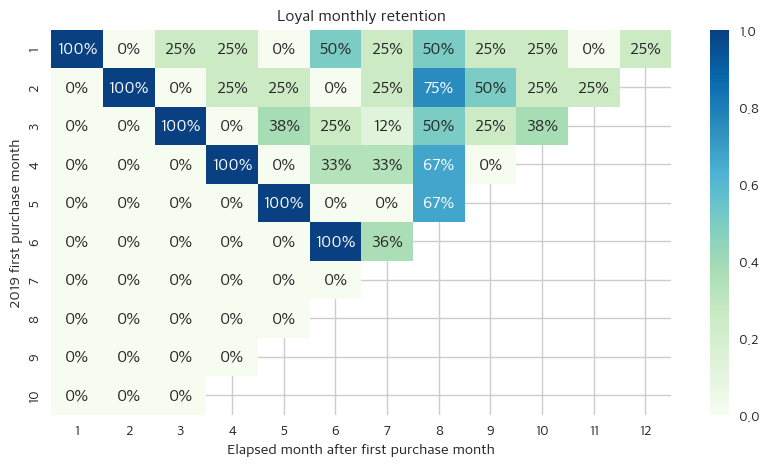

/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_99097/2858734992.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(temp, palette='Blues')


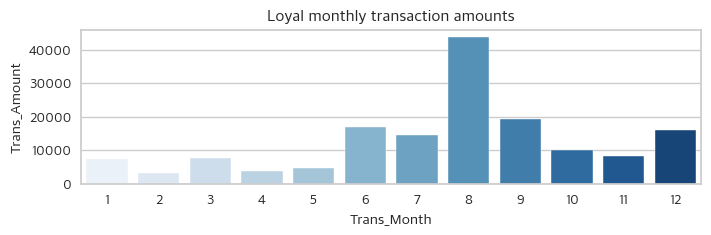

In [291]:
loyal_cohort = data_cohort[data_cohort['customer_segment'] == 'Loyal']

#Monthly retention for Loyal customers
plt.figure(figsize = (10,5))
plot_retention(loyal_cohort)

plt.title('Loyal monthly retention')
plt.ylabel('2019 first purchase month')
plt.xlabel('Elapsed month after first purchase month')
plt.show()

#Monthly transaction amounts for Loyal customers
plt.figure(figsize = (8,2))
temp = loyal_cohort.groupby('Trans_Month')['Trans_Amount'].sum()
sns.barplot(temp, palette='Blues')

plt.title('Loyal monthly transaction amounts')
plt.show()

- Loyal customers tend to revisit primarily in August.
- Most of the revenue from loyal customers is concentrated in August, too.
- Thus, propose promotions for popular categories after identifying the purchase categories of loyal customers in August.

/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_99097/1724797479.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pop_category[:5].index, y=pop_category[:5]
/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_99097/1724797479.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pop_category[:5].index, y=pop_category[:5]
/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_99097/1724797479.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


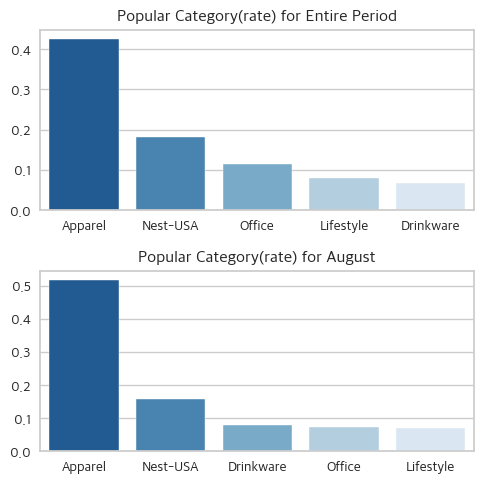

In [294]:
#Top 5 of categories (Entire period vs August)
fig,ax = plt.subplots(2,1, figsize = (5,5), constrained_layout = True)

pop_category = loyal_cohort['Product Category'].value_counts(normalize = True)

sns.barplot(x=pop_category[:5].index, y=pop_category[:5]
            , ax = ax[0], palette = 'Blues_r')
ax[0].set_title('Popular Category(rate) for Entire Period')
ax[0].set_ylabel('')
ax[0].set_xlabel('')

pop_category = loyal_cohort[loyal_cohort['Trans_Month'] == 8]['Product Category'].value_counts(normalize = True)
sns.barplot(x=pop_category[:5].index, y=pop_category[:5]
            , ax = ax[1], palette = 'Blues_r')
ax[1].set_title('Popular Category(rate) for August')
ax[1].set_ylabel('')
ax[1].set_xlabel('')

plt.tight_layout()
plt.show()

- The proportion of `Apparel`and `Dirnkware` has increased in August compared to the entire period.
- It is assumed that these two categories are related to the revisit in August.
- Therefore, propose promotions or cross-selling strategies for `Apparel & Dirnkware` concentrated in August.

## 5-3. Potential Customer

- Propose how to increase the visit frequency of potential customers
- Identify related categories by analyzing association rules
- Offer promotions that apply discounts when related categories are purchased together
- Enhance visit frequency through promotions

In [300]:
def cross_selling(df):
    data_association = df.groupby(['Date', 'Product Category'])['Quant'].sum().unstack().fillna(0)
    data_association[data_association > 0] = 1

    #Calculate support
    frequent_itemsets = apriori(data_association, min_support=0.3, use_colnames=True)
    association_rules_df = association_rules(frequent_itemsets, metric='lift', min_threshold=1.5)
    
    return association_rules_df.sort_values('lift',ascending = False)

In [302]:
potential_cohort = data_cohort[data_cohort['customer_segment'] == 'Potential']
cross = cross_selling(potential_cohort)[:5][['antecedents','consequents','support','confidence','lift']]
cross

,antecedents,consequents,support,confidence,lift
0,"(Drinkware, Apparel)",(Bags),0.314010,0.575221,1.526549
1,(Bags),"(Drinkware, Apparel)",0.314010,0.833333,1.526549
4,"(Drinkware, Nest-USA, Office)","(Apparel, Lifestyle)",0.338164,0.714286,1.524300
7,"(Apparel, Lifestyle)","(Drinkware, Nest-USA, Office)",0.338164,0.721649,1.524300
2,"(Drinkware, Office)","(Apparel, Lifestyle)",0.357488,0.704762,1.503976


- As a result of association analysis, there is the highest likelihood of purchasing `Bags` with `Apparel & Drinkware` together.
- Therefore, propose a discount promotion for bundled products of `Bags`, `Apparel`, and `Drinkware`.

## 5-4. Churn Customer

- Propose strategies to reactivate churn customers
- Identify popular categories
- Conduct promotions for popular categories
- Reactivate churn customers through promotions

/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_99097/1522216380.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=temp.index, y=temp.values, ax=ax[0], palette='GnBu')
/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_99097/1522216380.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=temp.index, y=temp.values, ax=ax[1], palette='GnBu')


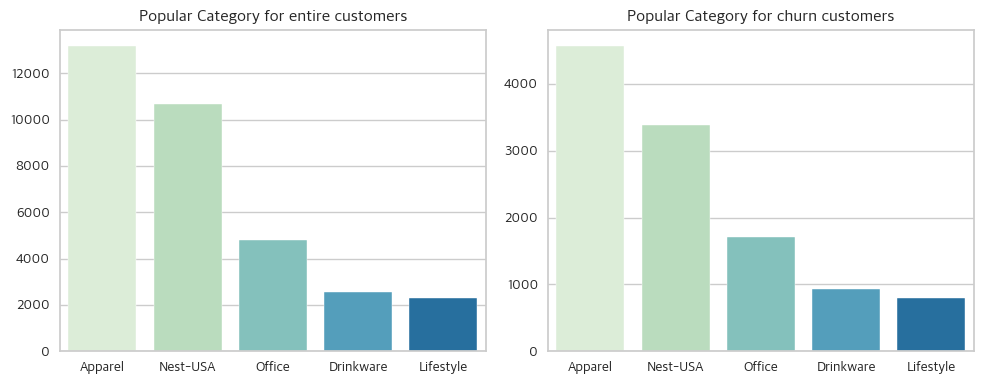

In [312]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
churn_cohort = data_cohort[data_cohort['customer_segment'] == 'Churn']

#Popular categories for entire customers
temp = data_cohort['Product Category'].value_counts()[:5]
sns.barplot(x=temp.index, y=temp.values, ax=ax[0], palette='GnBu')
ax[0].set_title('Popular Category for entire customers')
ax[0].set_xlabel('')

#Popular categories for churn customers
temp = churn_cohort['Product Category'].value_counts()[:5]
sns.barplot(x=temp.index, y=temp.values, ax=ax[1], palette='GnBu')
ax[1].set_title('Popular Category for churn customers')
ax[1].set_xlabel('')

plt.tight_layout()
plt.show()

- As a result of popular category analysis, churn customers primarily purchsed `Apparel`.
- Thus, it is proposed to offer promotions for `Apparel`(offer free gifts or special discount coupons).